In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric.transforms as T
import graph_tools
DTYPE = torch.float

from perso_simple_env import SimpleEnvironment

c:\Users\bt305570\Desktop\CS\tsunami\github\Tsunami\src\test_mesh\perso_simple_env.py:221: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xv, yv, c=processed_map, cmap="winter")


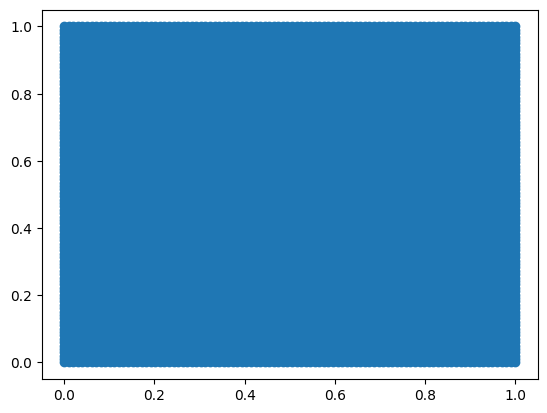

In [3]:
simple_env = SimpleEnvironment([0,0,1,1])
# simple_env.add_convex_polygon(np.array([[0,1],[1,1],[1,0]]))
simple_env.plot_map()

In [4]:
def create_random_disc(env_bounds,min_radius,max_radius):
    center_coords = np.random.rand(2)
    center_coords[0] = center_coords[0]*(env_bounds[2]-env_bounds[0])+env_bounds[0]
    center_coords[1] = center_coords[1]*(env_bounds[3]-env_bounds[1])+env_bounds[1]

    radius = np.random.rand(1)*(max_radius-min_radius)+min_radius

    return center_coords, radius

def create_random_rectangle(env_bounds,min_edge_length,max_edge_length):
    center_coords = np.random.rand(2)
    center_coords[0] = center_coords[0]*(env_bounds[2]-env_bounds[0])+env_bounds[0]
    center_coords[1] = center_coords[1]*(env_bounds[3]-env_bounds[1])+env_bounds[1]

    lengths = np.random.rand(2)*(max_edge_length-min_edge_length)+min_edge_length
    rect_points = [[sign_0*lengths[0]/2,sign_1*lengths[1]/2] for sign_0 in [-1,1] for sign_1 in [-1,1]]
    rect_points = np.array(rect_points)[[0,1,3,2]]

    theta = np.random.rand(1)[0]*(2*np.pi)
    rotation_matrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    points_coords = [center_coords+rotation_matrix @ point for point in rect_points]
    points_coords = np.array(points_coords)

    return points_coords

rect_coords = create_random_rectangle(simple_env.env_bounds,0.5,0.5)
print("rect_coords",rect_coords)
simple_env.add_convex_polygon(rect_coords)

# center_coords, radius=create_random_disc(simple_env.env_bounds,0.1,0.4)
# print(center_coords, radius)
# simple_env.add_disc(center_coords, radius)

rect_coords [[1.08519378 1.08629284]
 [1.32286736 0.64639368]
 [0.88296821 0.4087201 ]
 [0.64529463 0.84861926]]


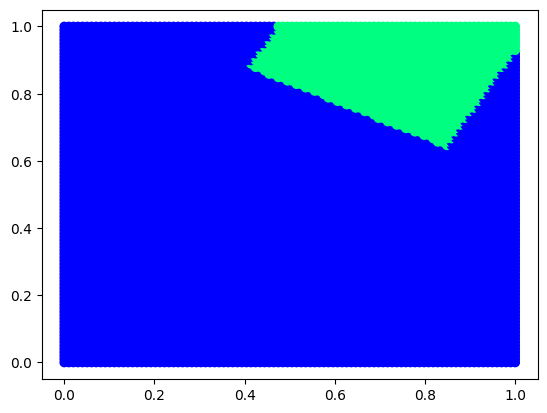

In [5]:
simple_env.plot_map()

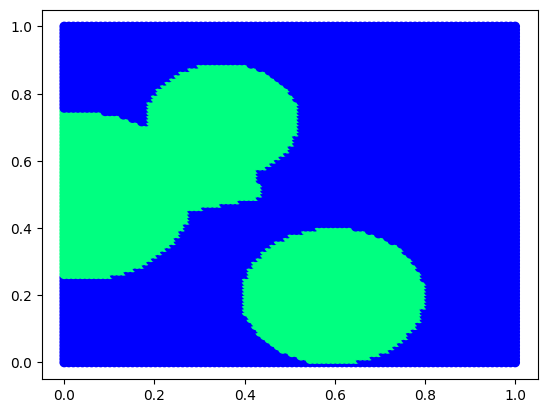

In [52]:
def create_random_2D_grid_array(n_meshes,env_bounds,n_elems_1_axis,n_objects_min,n_objects_max,min_radius,max_radius,min_edge_length,max_edge_length):
    masks = []
    for _ in range(n_meshes):
        simple_env = SimpleEnvironment(env_bounds,n_elems_1_axis)
        n_objects = np.random.randint(n_objects_min,n_objects_max+1)
        n_discs = np.random.randint(0,n_objects+1)

        for i in range(n_objects):
            if i<n_discs:
                center_coords, radius=create_random_disc(simple_env.env_bounds,min_radius,max_radius)
                simple_env.add_disc(center_coords, radius)
            else:
                rect_coords = create_random_rectangle(simple_env.env_bounds,min_edge_length,max_edge_length)
                simple_env.add_convex_polygon(rect_coords)
        simple_env.update_map()
        masks.append(simple_env.map)
        # to remove later on
        simple_env.plot_map()
    
    X = np.linspace(env_bounds[0], env_bounds[2], n_elems_1_axis)
    Y = np.linspace(env_bounds[1], env_bounds[3], n_elems_1_axis)

    xv, yv = np.meshgrid(X, Y)
    point_coords = np.stack([xv,yv],axis=-1)
    point_coords = np.transpose(point_coords,axes=(1,0,2))
    return point_coords,masks

point_coords,masks = create_random_2D_grid_array(1,[0,0,1,1],100,1,6,0.1,0.3,0.1,0.3)

In [53]:
def convert_2D_grid_array_to_2D_grid_graph(point_coords,mask):
    grid_graph = graph_tools.generate_normalized_grid_graph(point_coords.shape[0],point_coords.shape[1],True,DTYPE)
    
    point_coords = torch.tensor(point_coords)
    grid_graph.x = torch.flatten(point_coords,end_dim=1)
    grid_graph.pos = torch.flatten(point_coords,end_dim=1)

    nodes_to_remove = np.where(mask.flatten())[0]
    # isolate the nodes to remove
    edgeid_to_keep = set(range(grid_graph.num_edges))
    for nodeid_to_remove in nodes_to_remove:
        edgeid_with_nodeid = torch.where(grid_graph.edge_index==nodeid_to_remove)[1].tolist()
        edgeid_to_keep =  set(edgeid_to_keep) - set(edgeid_with_nodeid)
    
    edgeid_to_keep = list(edgeid_to_keep)
    grid_graph.edge_index = grid_graph.edge_index[:,edgeid_to_keep]
    
    # remove isolate nodes
    grid_graph = T.RemoveIsolatedNodes()(grid_graph)
    return grid_graph

graph = convert_2D_grid_array_to_2D_grid_graph(point_coords,masks[0])
# WARNING: with more resolution, try not to draw the graph...
# graph_tools.draw_graph(graph)

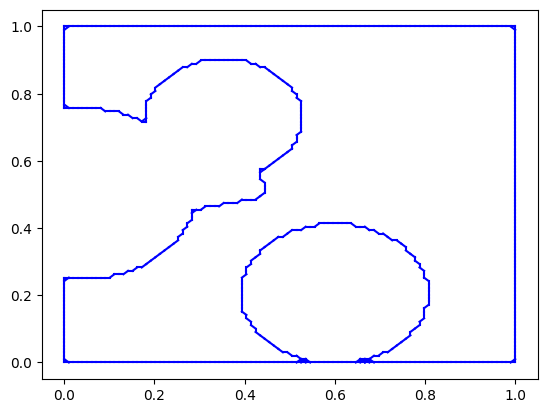

In [55]:

frontier=[]
count=torch.bincount(graph.edge_index[0])

Edge0=graph.edge_index[0]
Edge1=graph.edge_index[1]
i=range(len(count))
C1=(count[i]<=6)
C2=(Edge0<Edge1)
C1Edge0,C1Edge1=C1[graph.edge_index]
C=np.logical_and(C1Edge0,C1Edge1)
Cf=np.logical_and(C,C2)
seglist=[]

for i in range(len(Edge0)) :
    if Cf[i] :
        X=np.array(graph.pos[Edge0[i]])
        Y=np.array(graph.pos[Edge1[i]])   
        plt.plot([X[0],Y[0]],[X[1],Y[1]],c='b')
        seglist.append([X[0],X[1],Y[0],Y[1]])

plt.show()




  0%|          | 0/614 [00:00<?, ?it/s]c:\Users\bt305570\Desktop\CS\tsunami\github\Tsunami\src\test_mesh\dist.py:49: RuntimeWarning: divide by zero encountered in divide
  R = R + 1./phi**m
100%|██████████| 614/614 [00:00<00:00, 4868.78it/s]


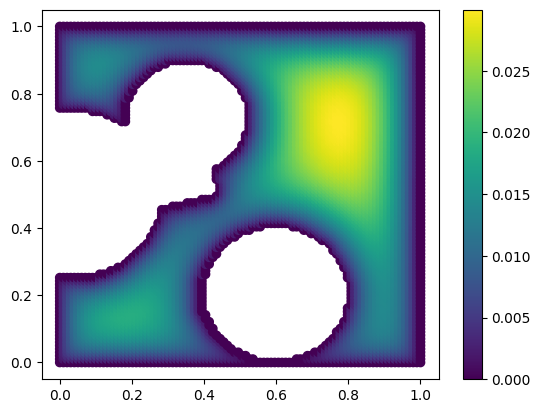

In [56]:
from dist import phi

X=np.array(graph.pos[:,0])
Y=np.array(graph.pos[:,1])
Z=phi(X,Y,np.array(seglist))

sc=plt.scatter(X,Y,c=Z)
plt.colorbar(sc)
plt.show()

